# Fake vs. Real News
December 28, 2020

## Read in data & import libraries

In [1]:
import nltk, string
import re
import numpy as np
import pandas as pd
import gensim
from collections import Counter #for stopword function
from sklearn.feature_extraction.text import CountVectorizer #for stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt #for elbow method
from sklearn.datasets.samples_generator import make_blobs #for elbow method
from sklearn.feature_extraction.text import TfidfVectorizer

/Users/ellie/Documents/anacondanavigator/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
fake = pd.read_csv("/Users/ellie/Documents/NC State/Side Project/Fake.csv")
true = pd.read_csv("/Users/ellie/Documents/NC State/Side Project/True.csv")

## Merging the datasets 

In [3]:
#Creating identifier column for whether the observation is from fake or true news
fake["source"] = 1
true["source"] = 0
dataframes = [fake, true]
merged = pd.concat(dataframes)
merged.tail()

,title,text,subject,date,source
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",0


In [4]:
merged.text[np.random.randint(1,23000)]

20168    Hillary s crowds have been nothing short of ab...
20168     ((This Sept. 12 story corrects name of sacked...
Name: text, dtype: object

## Splitting into Training, Test, and Validation

In [5]:
np.random.seed(100)
train, validate, test = np.split(merged.sample(frac = 1), [int(0.7*len(merged)), int(0.9*len(merged))])

## Remove special characters & make text uniform

In [6]:
stop_words = nltk.corpus.stopwords.words('english')
train["text"] = train["text"].str.lower()

In [7]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(list(train['text']))

In [8]:
stop_words = stop_words + ['quite',
  'features',
  'plenty',
  'it',
  'either',
  'said',
  'thing',   
  'Thing',
  'things',
  'Things',                         
  'one',                         
  'hitting',
  'hold',
  'least', 
  'shows',   
  'offers', 
  'well', 
  'next',   
  'like', 
  'theres', 
  'little', 
  'also', 
  'made',  
  'big', 
  'one', 
  'slightly',  
  'finishes', 
  'hints',
  'hint', 
  'note', 
  'nice', 
  'give',   
  'almost',  
  'tight', 
  'potential', 
  'weight', 
  'needs', 
  'pair', 
  'new', 
  'young', 
  'showing', 
  'packed', 
  'along', 
  'time', 
  'layers', 
  'simple', 
  'opens', 
  'yet', 
  'feel',
]

cv = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.8, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)

In [9]:
NUM_CLUSTERS = 2
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=25, n_init=10, random_state=42).fit(cv_matrix)

## Clustering Using K-Means 

In [10]:
#Appending column with cluster label to dataframe
train['kmeans_cluster'] = km.labels_
train.head()

,title,text,subject,date,source,kmeans_cluster
11383,IRS GIVES “After School Satan Club” Tax-Exempt...,after school satan club allowed by school dist...,politics,"Mar 17, 2017",1,0
17483,Talks seek to secure Islamic State withdrawal ...,"ain issa, syria (reuters) - remaining islamic ...",worldnews,"October 14, 2017",0,0
8214,Supreme Court rejects Michigan straight-ticket...,washington (reuters) - the u.s. supreme court ...,politicsNews,"September 9, 2016",0,0
4320,U.S. says strike hits 20 percent of Syria's op...,washington (reuters) - the u.s. cruise missile...,politicsNews,"April 10, 2017",0,0
7559,Republican EXPLODES After Obama Foils Evil Sc...,it s like president obama can t go a day witho...,News,"March 11, 2016",1,0


In [11]:
train1 = pd.DataFrame(train)

#Identifying accuracy of clusters
train1["accuracy"] = np.where(train1["source"] == train1["kmeans_cluster"], True, False)
train1.head()

,title,text,subject,date,source,kmeans_cluster,accuracy
11383,IRS GIVES “After School Satan Club” Tax-Exempt...,after school satan club allowed by school dist...,politics,"Mar 17, 2017",1,0,False
17483,Talks seek to secure Islamic State withdrawal ...,"ain issa, syria (reuters) - remaining islamic ...",worldnews,"October 14, 2017",0,0,True
8214,Supreme Court rejects Michigan straight-ticket...,washington (reuters) - the u.s. supreme court ...,politicsNews,"September 9, 2016",0,0,True
4320,U.S. says strike hits 20 percent of Syria's op...,washington (reuters) - the u.s. cruise missile...,politicsNews,"April 10, 2017",0,0,True
7559,Republican EXPLODES After Obama Foils Evil Sc...,it s like president obama can t go a day witho...,News,"March 11, 2016",1,0,False


In [12]:
train1.groupby(['accuracy']).agg(['count'])

,title,text,subject,date,source,kmeans_cluster
,count,count,count,count,count,count
accuracy,,,,,,
False,15210,15210,15210,15210,15210,15210
True,16218,16218,16218,16218,16218,16218


In [13]:
'''
Accuracy: 

Trues: 14412
Falses: 17016

14412/(31428) = 45% correct; Increasing n_int from 5 to 10 increases accuracy by 25%

'''

'\nAccuracy: \n\nTrues: 14412\nFalses: 17016\n\n14412/(31428) = 45% correct; Increasing n_int from 5 to 10 increases accuracy by 25%\n\n'

## TF - IDF 

In [14]:
'''Intuitively, TF-IDF implies the following. In any document Dj, if a term it occurs frequently, 
it's an important term for characterizing Dj. Moreover, if it does not occur in many other documents, 
it's an important term for distinguishing Dj from other documents. If two documents share terms with 
high term frequency and low document frequency, they are assumed to be similar.'''

#We can't use the elbow method on text data, so will do TF - IDF and then use elbow method

"Intuitively, TF-IDF implies the following. In any document Dj, if a term it occurs frequently, \nit's an important term for characterizing Dj. Moreover, if it does not occur in many other documents, \nit's an important term for distinguishing Dj from other documents. If two documents share terms with \nhigh term frequency and low document frequency, they are assumed to be similar."

In [15]:
train1.head()

,title,text,subject,date,source,kmeans_cluster,accuracy
11383,IRS GIVES “After School Satan Club” Tax-Exempt...,after school satan club allowed by school dist...,politics,"Mar 17, 2017",1,0,False
17483,Talks seek to secure Islamic State withdrawal ...,"ain issa, syria (reuters) - remaining islamic ...",worldnews,"October 14, 2017",0,0,True
8214,Supreme Court rejects Michigan straight-ticket...,washington (reuters) - the u.s. supreme court ...,politicsNews,"September 9, 2016",0,0,True
4320,U.S. says strike hits 20 percent of Syria's op...,washington (reuters) - the u.s. cruise missile...,politicsNews,"April 10, 2017",0,0,True
7559,Republican EXPLODES After Obama Foils Evil Sc...,it s like president obama can t go a day witho...,News,"March 11, 2016",1,0,False


In [16]:
train1.text[np.random.randint(1,23000)]

7932    (reuters) - oklahoma’s highest court on tuesda...
7932    it s fairly well-known that ted cruz has few f...
Name: text, dtype: object

In [17]:
train1["text"].str.split() # has to be str.split, not .split
train_text = train1['text'].tolist()
train_text = [d.split() for d in train_text]

In [18]:
#  Convert term vectors into gensim dictionary

dict = gensim.corpora.Dictionary( train_text )

corp = [ ]
for i in range( 0, len( train_text ) ):
    corp.append( dict.doc2bow( train_text[ i ] ) )

In [19]:
#  Create TF - IDF vectors based on term vectors bag-of-word corpora

tfidf_model = gensim.models.TfidfModel( corp )

tfidf = [ ]
for i in range( 0, len( corp ) ):
    tfidf.append( tfidf_model[ corp[ i ] ] )

#  Create pairwise document similarity index

n = len( dict )
index = gensim.similarities.SparseMatrixSimilarity( tfidf_model[ corp ], num_features = n )

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
import os, sys, email,re
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [21]:
data = train1['text']


tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',
                             max_features = 100)
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

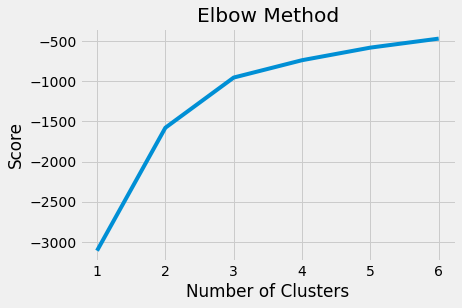

In [22]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)

number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

## Evaluating K-Means Now 

In [23]:
NUM_CLUSTERS = 2
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=25, n_init=10, random_state=42).fit(cv_matrix)

In [24]:
#Appending column with cluster label to dataframe
train1['kmeans_cluster_testing'] = km.labels_
train1.head()

,title,text,subject,date,source,kmeans_cluster,accuracy,kmeans_cluster_testing
11383,IRS GIVES “After School Satan Club” Tax-Exempt...,after school satan club allowed by school dist...,politics,"Mar 17, 2017",1,0,False,0
17483,Talks seek to secure Islamic State withdrawal ...,"ain issa, syria (reuters) - remaining islamic ...",worldnews,"October 14, 2017",0,0,True,0
8214,Supreme Court rejects Michigan straight-ticket...,washington (reuters) - the u.s. supreme court ...,politicsNews,"September 9, 2016",0,0,True,0
4320,U.S. says strike hits 20 percent of Syria's op...,washington (reuters) - the u.s. cruise missile...,politicsNews,"April 10, 2017",0,0,True,0
7559,Republican EXPLODES After Obama Foils Evil Sc...,it s like president obama can t go a day witho...,News,"March 11, 2016",1,0,False,0


In [25]:
#Identifying accuracy of clusters
train1["accuracy"] = np.where(train1["source"] == train1["kmeans_cluster_testing"], True, False)
train1.groupby(['accuracy']).agg(['count'])

,title,text,subject,date,source,kmeans_cluster,kmeans_cluster_testing
,count,count,count,count,count,count,count
accuracy,,,,,,,
False,15210,15210,15210,15210,15210,15210,15210
True,16218,16218,16218,16218,16218,16218,16218


In [ ]:
'''
Accuracy: 

Looks like 2 is the optimal number of clusters, as it provides highest accuracy
'''

## Evaluating Performance on Validation Data 

In [26]:
#Normalizing the data first
validate["text"] = validate["text"].str.lower()
normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(list(validate['text']))

In [27]:
cv = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.8, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)

In [28]:
NUM_CLUSTERS = 2
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=25, n_init=10, random_state=42).fit(cv_matrix)

In [29]:
#Appending column with cluster label to dataframe
validate['kmeans_cluster'] = km.labels_
validate.head()

,title,text,subject,date,source,kmeans_cluster
767,New York Mayor de Blasio wins re-election in w...,new york (reuters) - democratic new york city ...,politicsNews,"November 7, 2017",0,0
19737,U.S. lawmaker wants North Korea out of the U.N.,washington (reuters) - the chairman of the u.s...,worldnews,"September 18, 2017",0,0
16120,CUBANS BRUTALLY ATTACK Brave Man Waving US Fla...,this is what having no freedom of speech looks...,Government News,"May 2, 2017",1,0
15604,MISS ME YET? CNN Poll Shows America Had A Diff...,"unfortunately, our troops have been affected m...",politics,"Jun 3, 2015",1,0
5020,WATCH: A Nazi Apologist Has Created A Group F...,jayme liardi makes no secret of the fact that ...,News,"August 16, 2016",1,1


In [30]:
validate1 = pd.DataFrame(validate)

#Identifying accuracy of clusters
validate1["accuracy"] = np.where(validate1["source"] == validate1["kmeans_cluster"], True, False)
validate1.head()

,title,text,subject,date,source,kmeans_cluster,accuracy
767,New York Mayor de Blasio wins re-election in w...,new york (reuters) - democratic new york city ...,politicsNews,"November 7, 2017",0,0,True
19737,U.S. lawmaker wants North Korea out of the U.N.,washington (reuters) - the chairman of the u.s...,worldnews,"September 18, 2017",0,0,True
16120,CUBANS BRUTALLY ATTACK Brave Man Waving US Fla...,this is what having no freedom of speech looks...,Government News,"May 2, 2017",1,0,False
15604,MISS ME YET? CNN Poll Shows America Had A Diff...,"unfortunately, our troops have been affected m...",politics,"Jun 3, 2015",1,0,False
5020,WATCH: A Nazi Apologist Has Created A Group F...,jayme liardi makes no secret of the fact that ...,News,"August 16, 2016",1,1,True


In [31]:
validate1.groupby(['accuracy']).agg(['count'])

,title,text,subject,date,source,kmeans_cluster
,count,count,count,count,count,count
accuracy,,,,,,
False,4288,4288,4288,4288,4288,4288
True,4692,4692,4692,4692,4692,4692


In [ ]:
'''
Accuracy on validation data: 46%
'''

## Evaluating Performance on Test Data 

In [32]:
#Normalizing the data first
test["text"] = test["text"].str.lower()
normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(list(test['text']))

In [33]:
cv = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.8, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)

In [34]:
NUM_CLUSTERS = 2
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=25, n_init=10, random_state=42).fit(cv_matrix)

In [35]:
#Appending column with cluster label to dataframe
test['kmeans_cluster'] = km.labels_
test.head()

,title,text,subject,date,source,kmeans_cluster
6833,Temporary U.S. government funding bill hits sn...,washington (reuters) - the u.s. house of repre...,politicsNews,"December 8, 2016",0,1
3977,JUST IN: Republicans In Florida Are Giving On...,what many people have been predicting througho...,News,"November 1, 2016",1,1
15291,Tillerson says no decision yet on Trump-Putin ...,beijing (reuters) - u.s. secretary of state re...,worldnews,"November 9, 2017",0,1
21929,CLOAKED IN CONSPIRACY: Overview of JFK Files R...,shawn helton 21st century wiresince late octob...,US_News,"December 14, 2017",1,0
21559,OBAMA’S ARROGANCE: WATCH As He Admonishes Repo...,being called out for his utter incompetence as...,left-news,"Jul 15, 2015",1,1


In [36]:
test1 = pd.DataFrame(test)

#Identifying accuracy of clusters
test1["accuracy"] = np.where(test1["source"] == test1["kmeans_cluster"], True, False)
test1.head()

,title,text,subject,date,source,kmeans_cluster,accuracy
6833,Temporary U.S. government funding bill hits sn...,washington (reuters) - the u.s. house of repre...,politicsNews,"December 8, 2016",0,1,False
3977,JUST IN: Republicans In Florida Are Giving On...,what many people have been predicting througho...,News,"November 1, 2016",1,1,True
15291,Tillerson says no decision yet on Trump-Putin ...,beijing (reuters) - u.s. secretary of state re...,worldnews,"November 9, 2017",0,1,False
21929,CLOAKED IN CONSPIRACY: Overview of JFK Files R...,shawn helton 21st century wiresince late octob...,US_News,"December 14, 2017",1,0,False
21559,OBAMA’S ARROGANCE: WATCH As He Admonishes Repo...,being called out for his utter incompetence as...,left-news,"Jul 15, 2015",1,1,True


In [37]:
test1.groupby(['accuracy']).agg(['count'])

,title,text,subject,date,source,kmeans_cluster
,count,count,count,count,count,count
accuracy,,,,,,
False,2299,2299,2299,2299,2299,2299
True,2191,2191,2191,2191,2191,2191


In [ ]:
'''
Accuracy on test data: 47%
'''

## Just for fun: Word Cloud for each Cluster & for Real and Fake News

In [39]:
#To get wordcloud to import properly, had to do the following:
import sys
print(sys.executable)

'''
Then in the terminal, copy output from the print command and run this: 
path/to/python -m pip install some_package
'''

/Users/ellie/Documents/anacondanavigator/anaconda3/bin/python


'\nThen in the terminal, copy output from the print command and run this: \npath/to/python -m pip install some_package\n'

In [40]:
from wordcloud import WordCloud, STOPWORDS 

comment_words = '' 
stopwords = set(STOPWORDS) 

In [41]:
cluster1 = train1.loc[(train1['kmeans_cluster'] == 1)]
cluster2 = train1.loc[(train1['kmeans_cluster'] == 0)]

fake_news = train1.loc[(train1['source'] == 1)]
real_news = train1.loc[(train1['source'] == 0)]

In [42]:
for val in cluster1.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

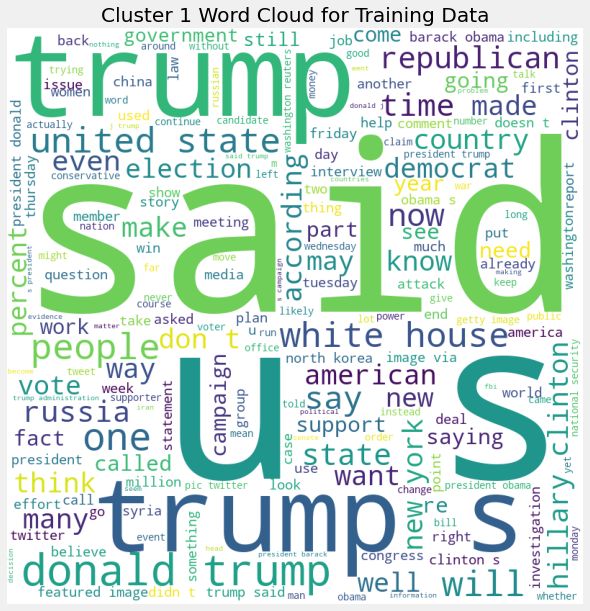

In [44]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Cluster 1 Word Cloud for Training Data")
  
plt.show() 

In [45]:
for val in cluster2.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

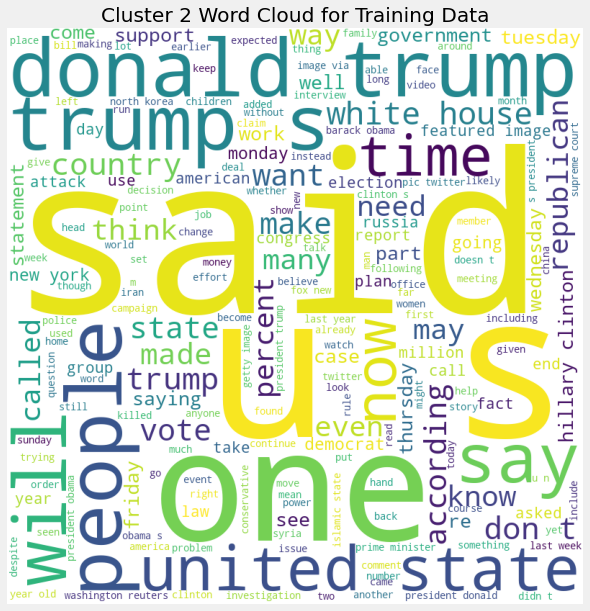

In [32]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Cluster 2 Word Cloud for Training Data")
  
plt.show() 

In [33]:
for val in fake_news.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

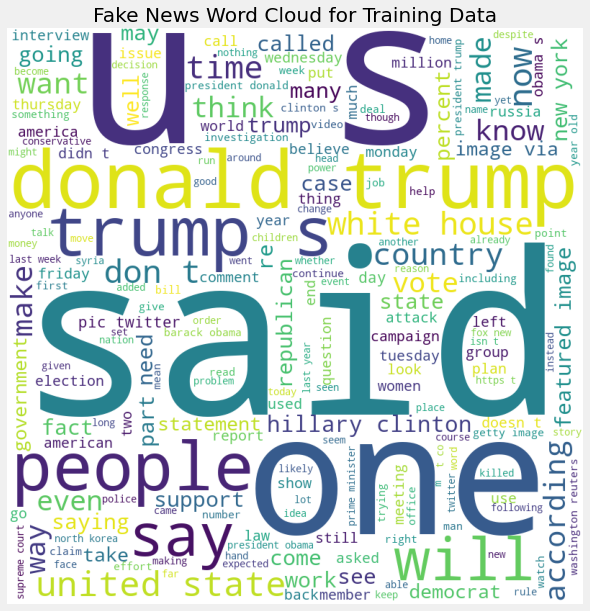

In [34]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Fake News Word Cloud for Training Data")
  
plt.show() 

In [35]:
for val in real_news.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

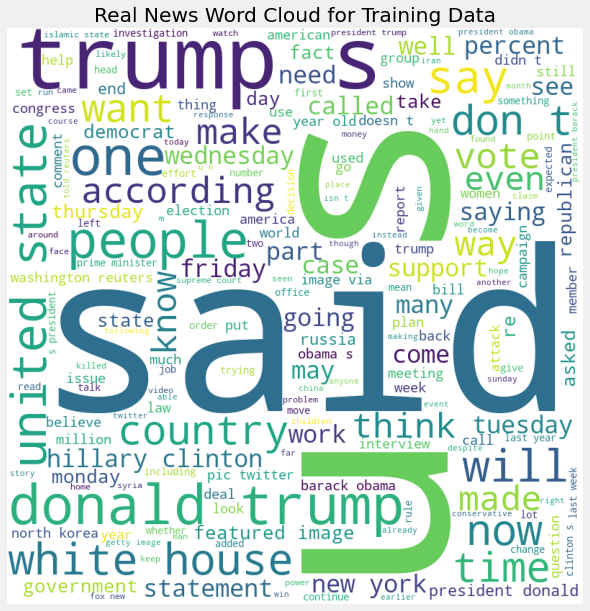

In [36]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Real News Word Cloud for Training Data")
  
plt.show() 